# Calculate wind capacity factors for NEM region using 20min BARRA-C2

In [37]:
client.close()
cluster.close()

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=48:mem=179GB


In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [38]:
walltime = "00:30:00"
cores = 24
memory = str(4 * cores) + "GB"

cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    processes=cores,
    job_extra_directives=[
        "-q normal",
        "-P dt6",
        "-l ncpus="+str(cores),
        "-l mem="+str(memory),
        "-l storage=gdata/xp65+gdata/w42+gdata/rt52+gdata/ob53+scratch/w42"
        # "-l storage=gdata/xp65"
    ],
    local_directory="$TMPDIR",
    job_directives_skip=["select"],
    # python="/g/data/xp65/public/apps/med_conda_scripts/analysis3-25.08.d/bin/python",
    # job_script_prologue=['module load conda/analysis3-25.08'],
    log_directory="/scratch/w42/dr6273/tmp/logs"
)

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=24:mem=90GB


In [39]:
cluster.scale(jobs=1)
client = Client(cluster)

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=24:mem=90GB


In [40]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.31:42541,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

In [6]:
%cd /g/data/w42/dr6273/work/wind_power_comparison/
import functions as fn

/g/data/w42/dr6273/work/wind_power_comparison


In [7]:
barra_path = "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/"
write_path = "/scratch/w42/dr6273/BARRA-C2/"

In [8]:
# # Box encompassing NEM REZs
# lons = slice(133.5, 153.7)
# lats = slice(-43.4, -13.9)
lons = fn.get_rez_boundary()["lon"]
lats = fn.get_rez_boundary()["lat"]

### Compute wind speed

In [9]:
def windspeed(u, v):
    """
    Compute windspeed from u and v
    
    u: array of zonal wind
    v: array of meridional wind
    """
    return np.sqrt(u ** 2 + v ** 2)

In [10]:
def open_barra(fp, lat_slice, lon_slice, lat_name="lat", lon_name="lon"):
    """
    Open multiple files and preprocess to region.
    
    fp: str, path to file. Should not include files, only the path to dir.
    lat_slice, lon_slice: slice of lat/lon to subset
    lat_name, lon_name: names of lat/lon coords.
    """
    def preprocess(ds):
        # ds = ds.rename({lat_name: "lat"})
        # ds = ds.rename({lon_name: "lon"})
        ds = ds.sel(lon=lon_slice, lat=lat_slice)
        # ds["time"] = ds["time"].dt.round(freq="20min")
        return ds.astype("float32")
    
    ds = xr.open_mfdataset(
        fp,
        preprocess=preprocess,
        chunks={"time": "300MB"},# "lat": -1, "lon": -1},
        concat_dim="time",
        combine="nested",
        compat="override",
        coords="minimal",
        data_vars="minimal",
        # decode_times=True
        # parallel=True
    )
    return ds

In [11]:
def get_filename(variable, frequency, year, month):
    """
    Return BARRA-C2 AUST-04 historical data filepaths
    
    variable: str, variable name e.g. ua100m
    frequency: str, timestep e.g. 20min, 1hr
    year: str
    month: str, month in format '01', '02', ..., '12'
    """
    file_template = variable + "_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_" + frequency + "_"
    return barra_path + frequency + "/" + variable + "/latest/" + file_template + year + month + "-" + year + month + ".nc"

In [26]:
years = range(1979, 2025)
freq = "20min"
height_str = "100m"
month_str = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

In [18]:
years[41:]

range(2020, 2025)

In [19]:
# client.restart()

In [19]:
for year in years[41:]:
    if year % 5 == 0:
        print(year)
        
    monthly_arrays = []
    for month in month_str[:]:
        
        u = open_barra(
            get_filename("ua"+height_str, freq, str(year), month),
            lats,
            lons
        )
        v = open_barra(
            get_filename("va"+height_str, freq, str(year), month),
            lats,
            lons
        )
        w = windspeed(
            u.rename({"ua"+height_str: "w"+height_str}),
            v.rename({"va"+height_str: "w"+height_str})
        )
        # w = w.chunk({"time": 200, "lat": -1, "lon": -1})
        # w = w.persist()
        
        cf = fn.capacity_factor_vdW(w["w"+height_str])
                
        # Chunk size of 72 as it is the greatest common divisor of
        #. the different time steps associated with each month
        cf = cf.chunk({"time": 72, "lat": -1, "lon": -1})
        
        cf = cf.to_dataset(name="cf"+height_str)
        
        encoding = {
            "cf"+height_str: {"dtype": "float32"}
        }
        
        if month == "01":
            cf.to_zarr(
                write_path + "derived/wind_capacity_factor/cf" + height_str + "_vdW_BARRA-C2_" + freq + "_" + str(year) + ".zarr",
                mode="w",
                encoding=encoding,
                consolidated=True,
            )
        else:
            cf.to_zarr(
                write_path + "derived/wind_capacity_factor/cf" + height_str + "_vdW_BARRA-C2_" + freq + "_" + str(year) + ".zarr",
                mode="a",
                append_dim="time",
                consolidated=True,
            )

2020


### Sense-check that 1-hour data matches the same time steps of 20min data

In [55]:
year = 2000
# freq1 = "20min"
height_str = "100m"
month = "06"
# month_str = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

In [25]:
u20min = open_barra(
    get_filename("ua"+height_str, "20min", str(year), month),
    lats,
    lons
)

In [48]:
u1hr = open_barra(
    get_filename("ua"+height_str, "1hr", str(year), month),
    lats,
    lons
)

In [33]:
lat = -30
lon = 150

In [49]:
u20 = u20min.ua100m.sel(time=slice(None, None, 3)).sel(lat=lat, lon=lon, method="nearest").compute()

In [51]:
u1h = u1hr.ua100m.sel(lat=lat, lon=lon, method="nearest").compute()

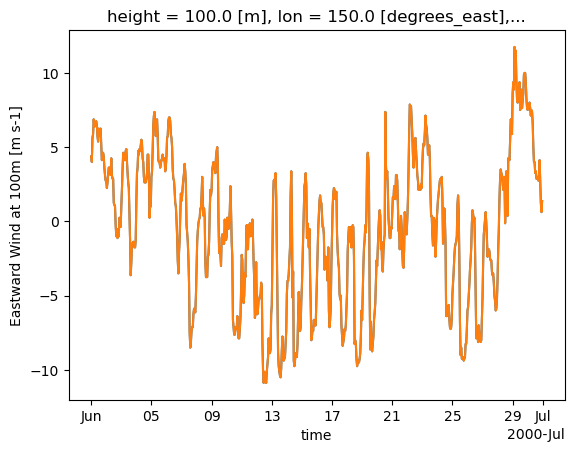

In [52]:
u20.plot()
u1h.plot()

# Close cluster

In [56]:
client.close()
cluster.close()

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=24:mem=90GB
